In [ ]:
# ============================================================
# 0) Environment: pip installs (RUN THIS CELL FIRST IN COLAB)
# ============================================================
# Pinned versions known to work together in Colab as of 2025
!pip -q install "qiskit==1.2.1" "qiskit-aer==0.15.1" "qiskit-algorithms==0.3.0" "qiskit-optimization==0.6.1" \
                "matplotlib>=3.8" "pandas>=2.1" "numpy>=1.26" "networkx>=3.2"

# Silence some warnings for clean output
import warnings, os, math, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.1/126.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
# ============================================================
# 1) Data: load tiny VRP dataset (or create if missing)
# ============================================================
import pandas as pd
from io import StringIO

CSV_TEXT = """location,x,y,earliest,latest
depot,0,0,0,24
F1,3,1,8,12
F2,-2,4,9,14
F3,5,-3,7,11
F4,-4,-2,10,16
"""

# If you host the CSV, replace StringIO(CSV_TEXT) with your path or raw URL.
df = pd.read_csv(StringIO(CSV_TEXT))
df

,location,x,y,earliest,latest
0,depot,0,0,0,24
1,F1,3,1,8,12
2,F2,-2,4,9,14
3,F3,5,-3,7,11
4,F4,-4,-2,10,16


In [ ]:
# ============================================================
# 2) Distances + Classical Baseline (Back-and-Forth)
#    Route pattern: depot -> Fi -> depot -> Fj -> depot -> ...
# ============================================================
import numpy as np

locations = df["location"].tolist()
coords = df.set_index("location")[["x","y"]].to_dict("index")
time_windows = df.set_index("location")[["earliest","latest"]].to_dict("index")

def euclid(a, b):
    return float(np.hypot(coords[a]["x"]-coords[b]["x"], coords[a]["y"]-coords[b]["y"]))

all_nodes = locations[:]  # ['depot','F1','F2','F3','F4']
customers = [n for n in all_nodes if n != "depot"]

# Pairwise distances (used minimally here)
dist = { (i,j): (0.0 if i==j else euclid(i,j)) for i in all_nodes for j in all_nodes }

# Round-trip cost to visit customer i once (independent of order)
round_trip = { i: dist[("depot", i)] + dist[(i, "depot")] for i in customers }

# Average round-trip and average "to" time for nominal arrival approximations
avg_round = float(np.mean([round_trip[i] for i in customers]))
avg_to = float(np.mean([dist[("depot", i)] for i in customers]))

# Nominal arrival times at position k (arrival to customer at visit k)
# We approximate: start at time 0; before visit k, we've already completed (k-1) average round-trips,
# then we travel to the next customer (avg_to).
T_pos = {k: int(round((k-1)*avg_round + avg_to)) for k in range(1, len(customers)+1)}

def schedule_distance(route_customers):
    """Total geometric distance for back-and-forth schedule (sum of round-trips)."""
    return float(sum(round_trip[i] for i in route_customers))

def schedule_route_list(route_customers):
    """Expand to full route list with depot between every visit."""
    r = ["depot"]
    for c in route_customers:
        r += [c, "depot"]
    return r

# --- Classical baseline heuristic focused on time windows ---
# Greedy: at each step k, pick the customer whose window best matches T_pos[k].
def greedy_time_window_order():
    remaining = customers[:]
    order = []
    for k in range(1, len(customers)+1):
        Tk = T_pos[k]
        # Score: 0 if within window, else distance to nearest window bound
        def score(c):
            e, l = time_windows[c]["earliest"], time_windows[c]["latest"]
            if e <= Tk <= l:
                return 0
            return min(abs(Tk - e), abs(Tk - l))
        c_best = min(remaining, key=score)
        order.append(c_best)
        remaining.remove(c_best)
    return order

baseline_order = greedy_time_window_order()
baseline_distance = schedule_distance(baseline_order)
baseline_route = schedule_route_list(baseline_order)

print("Baseline back-and-forth order:", " -> ".join(baseline_order))
print("Baseline back-and-forth expanded route:", " -> ".join(baseline_route))
print("Baseline total distance (sum of round-trips): %.3f" % baseline_distance)

Baseline back-and-forth order: F3 -> F2 -> F4 -> F1
Baseline back-and-forth expanded route: depot -> F3 -> depot -> F2 -> depot -> F4 -> depot -> F1 -> depot
Baseline total distance (sum of round-trips): 35.875


In [ ]:
# ============================================================
# 3) QUBO (Back-and-Forth + soft time-window penalty)
# ------------------------------------------------------------
# Variables x[i,k] for customer i and position k=1..m (m=4):
#   x[i,k] = 1 iff customer i is visited at position k (each position is one visit)
# Objective:
#   Sum_k sum_i (round_trip[i]) * x[i,k]
# Constraints (penalty A):
#   - Each customer appears exactly once (row one-hot)
#   - Each position has exactly one customer (col one-hot)
# Time-window penalty (B):
#   If position k's nominal arrival T_pos[k] is outside [e_i, l_i], add B * x[i,k]
# ============================================================
from qiskit_optimization import QuadraticProgram

m = len(customers)  # number of positions = number of customers
A = 20.0  # hard one-hot penalties
B = 5.0   # soft time-window penalty

qp = QuadraticProgram()

# Create x[i,k] variables
for i in customers:
    for k in range(1, m+1):
        qp.binary_var(f"x_{i}_{k}")

# Build linear/quadratic objective arrays
name_to_idx = {v.name: idx for idx, v in enumerate(qp.variables)}
lin = np.zeros(len(qp.variables))
quad = np.zeros((len(qp.variables), len(qp.variables)))

def add_linear(varname, coeff):
    lin[name_to_idx[varname]] += coeff

def add_quadratic(v1, v2, coeff):
    i, j = name_to_idx[v1], name_to_idx[v2]
    quad[i,j] += coeff
    if i != j:
        quad[j,i] += coeff

# --- Distance objective: round-trip for chosen customer at each position ---
for i in customers:
    for k in range(1, m+1):
        add_linear(f"x_{i}_{k}", round_trip[i])

# --- One-hot constraints as penalties ---
# Each customer exactly once: sum_k x[i,k] == 1
for i in customers:
    vars_i = [f"x_{i}_{k}" for k in range(1, m+1)]
    for v in vars_i:
        add_linear(v, A)  # + x
    for a in range(len(vars_i)):
        for b in range(a+1, len(vars_i)):
            add_quadratic(vars_i[a], vars_i[b], 2*A)  # + 2 x_a x_b
    for v in vars_i:
        add_linear(v, -2*A)  # - 2 x

# Each position exactly one customer: sum_i x[i,k] == 1
for k in range(1, m+1):
    vars_k = [f"x_{i}_{k}" for i in customers]
    for v in vars_k:
        add_linear(v, A)
    for a in range(len(vars_k)):
        for b in range(a+1, len(vars_k)):
            add_quadratic(vars_k[a], vars_k[b], 2*A)
    for v in vars_k:
        add_linear(v, -2*A)

# --- Time-window soft penalty ---
for i in customers:
    e_i, l_i = time_windows[i]["earliest"], time_windows[i]["latest"]
    for k in range(1, m+1):
        Tk = T_pos[k]
        if not (e_i <= Tk <= l_i):
            add_linear(f"x_{i}_{k}", B)

# Finalize objective
qp.minimize(linear=lin, quadratic=quad)
print(qp)

minimize 80*x_F1_1*x_F1_2 + 80*x_F1_1*x_F1_3 + 80*x_F1_1*x_F1_4 + 80*x_F1_1*x_F2_1 + 80*x_F1_1*x_F3_1 + 80*x_F1_1*x_F4_1 + 80*x_F1_2*x_F1_3 + 80*x_F1_2*x_F1_4 + 80*x_F1_2*x_F2_2 + 80*x_F1_2*x_F3_2 + 80*x_F1_2*x_F4_2 + 80*x_F1_3*x_F1_4 + 80*x_F1_3*x_F2_3 + 80*x_F1_3*x_F3_3 + 80*x_F1_3*x_F4_3 + 80*x_F1_4*x_F2_4 + 80*x_F1_4*x_F3_4 + 80*x_F1_4*x_F4_4 + 80*x_F2_1*x_F2_2 + 80*x_F2_1*x_F2_3 + 80*x_F2_1*x_F2_4 + 80*x_F2_1*x_F3_1 + 80*x_F2_1*x_F4_1 + 80*x_F2_2*x_F2_3 + 80*x_F2_2*x_F2_4 + 80*x_F2_2*x_F3_2 + 80*x_F2_2*x_F4_2 + 80*x_F2_3*x_F2_4 + 80*x_F2_3*x_F3_3 + 80*x_F2_3*x_F4_3 + 80*x_F2_4*x_F3_4 + 80*x_F2_4*x_F4_4 + 80*x_F3_1*x_F3_2 + 80*x_F3_1*x_F3_3 + 80*x_F3_1*x_F3_4 + 80*x_F3_1*x_F4_1 + 80*x_F3_2*x_F3_3 + 80*x_F3_2*x_F3_4 + 80*x_F3_2*x_F4_2 + 80*x_F3_3*x_F3_4 + 80*x_F3_3*x_F4_3 + 80*x_F3_4*x_F4_4 + 80*x_F4_1*x_F4_2 + 80*x_F4_1*x_F4_3 + 80*x_F4_1*x_F4_4 + 80*x_F4_2*x_F4_3 + 80*x_F4_2*x_F4_4 + 80*x_F4_3*x_F4_4 - 28.675444679663244*x_F1_1 - 28.675444679663244*x_F1_2 - 28.675444679663244*x_F1

In [ ]:
# ============================================================
# 4) Solve with QAOA (p=1 and p=2), both Statevector and QASM
# ============================================================
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

def solve_with_qaoa(p=1, shots=None, seed=42):
    # Note: qiskit-algorithms 0.3.0 QAOA(..., seed=) is not supported
    # For simple reproducibility, you could set algorithm_globals.random_seed = seed,
    # but we'll keep it minimal here.

    if shots is None:
        sampler = Sampler(run_options={"shots": None}, backend_options={"method":"statevector"})
    else:
        sampler = Sampler(run_options={"shots": shots}, backend_options={"method":"automatic"})

    qaoa = QAOA(sampler=sampler, optimizer=COBYLA(maxiter=100), reps=p)
    opt = MinimumEigenOptimizer(qaoa)
    result = opt.solve(qp)
    return result, qaoa

# Experiments
experiments = [
    ("p=1 statevector", dict(p=1, shots=None)),
    ("p=2 statevector", dict(p=2, shots=None)),
    ("p=1 qasm 2000 shots", dict(p=1, shots=2000)),
    ("p=2 qasm 2000 shots", dict(p=2, shots=2000)),
]

results = []
for label, params in experiments:
    print(f"\n=== Running {label} ===")
    res, qaoa = solve_with_qaoa(**params)
    print("Status:", res.status)
    print("Objective value (round-trips + penalties):", round(res.fval,3))

    # Decode order from solution x[i,k]
    sol = res.x
    pos_to_i = {}
    for i in customers:
        for k in range(1, m+1):
            v = f"x_{i}_{k}"
            if sol[ qp.variables_index[v] ] > 0.5:   # dict lookup, not call
                pos_to_i[k] = i

    # Build order list
    order = [pos_to_i.get(k, "(?)") for k in range(1, m+1)]
    expanded_route = schedule_route_list(order) if all(o in customers for o in order) else None
    true_distance = schedule_distance(order) if all(o in customers for o in order) else float("nan")

    results.append((label, res.fval, true_distance, order, expanded_route, qaoa))
    print("Decoded visit order:", " -> ".join(order))
    if expanded_route:
        print("Expanded route:", " -> ".join(expanded_route))
    print("Total geometric distance (sum of round-trips):", true_distance)


=== Running p=1 statevector ===
Status: OptimizationResultStatus.SUCCESS
Objective value (round-trips + penalties): -109.125
Decoded visit order: F4 -> F2 -> F3 -> F1
Expanded route: depot -> F4 -> depot -> F2 -> depot -> F3 -> depot -> F1 -> depot
Total geometric distance (sum of round-trips): 35.87500293002568

=== Running p=2 statevector ===
Status: OptimizationResultStatus.SUCCESS
Objective value (round-trips + penalties): -104.125
Decoded visit order: F4 -> F3 -> F2 -> F1
Expanded route: depot -> F4 -> depot -> F3 -> depot -> F2 -> depot -> F1 -> depot
Total geometric distance (sum of round-trips): 35.87500293002568

=== Running p=1 qasm 2000 shots ===
Status: OptimizationResultStatus.SUCCESS
Objective value (round-trips + penalties): -109.125
Decoded visit order: F1 -> F4 -> F3 -> F2
Expanded route: depot -> F1 -> depot -> F4 -> depot -> F3 -> depot -> F2 -> depot
Total geometric distance (sum of round-trips): 35.87500293002568

=== Running p=2 qasm 2000 shots ===
Status: Optimi

         ┌───┐»
    q_0: ┤ H ├»
         ├───┤»
    q_1: ┤ H ├»
         ├───┤»
    q_2: ┤ H ├»
         ├───┤»
    q_3: ┤ H ├»
         ├───┤»
    q_4: ┤ H ├»
         ├───┤»
    q_5: ┤ H ├»
         ├───┤»
    q_6: ┤ H ├»
         ├───┤»
    q_7: ┤ H ├»
         ├───┤»
    q_8: ┤ H ├»
         ├───┤»
    q_9: ┤ H ├»
         ├───┤»
   q_10: ┤ H ├»
         ├───┤»
   q_11: ┤ H ├»
         ├───┤»
   q_12: ┤ H ├»
         ├───┤»
   q_13: ┤ H ├»
         ├───┤»
   q_14: ┤ H ├»
         ├───┤»
   q_15: ┤ H ├»
         └───┘»
meas: 16/═════»
              »
«         ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

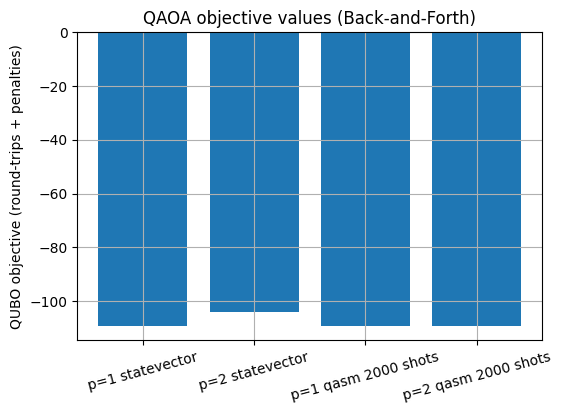

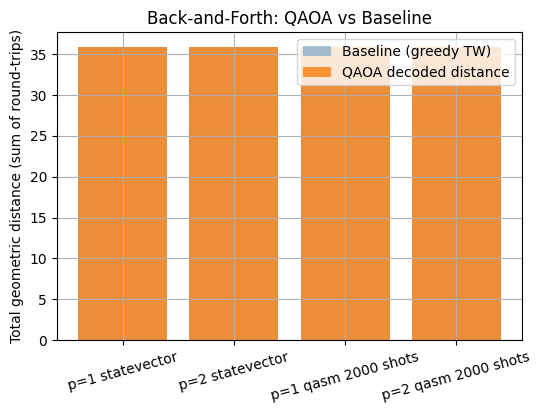

In [ ]:
# ============================================================
# 5) Visuals: Show QAOA circuit (ansatz) and performance plots
# ============================================================
last_qaoa = results[-1][-1]
print(last_qaoa.ansatz)
try:
    last_qaoa.ansatz.decompose().draw(output="mpl")
    plt.show()
except Exception as e:
    print("Circuit draw skipped:", e)

labels = [r[0] for r in results]
qubo_vals = [r[1] for r in results]
true_dists = [r[2] for r in results]

plt.figure()
plt.bar(range(len(labels)), qubo_vals)
plt.xticks(range(len(labels)), labels, rotation=15)
plt.ylabel("QUBO objective (round-trips + penalties)")
plt.title("QAOA objective values (Back-and-Forth)")
plt.show()

plt.figure()
plt.bar(range(len(labels)), [baseline_distance]*len(labels), alpha=0.4, label="Baseline (greedy TW)")
plt.bar(range(len(labels)), [d if not np.isnan(d) else 0 for d in true_dists], alpha=0.8, label="QAOA decoded distance")
plt.xticks(range(len(labels)), labels, rotation=15)
plt.ylabel("Total geometric distance (sum of round-trips)")
plt.title("Back-and-Forth: QAOA vs Baseline")
plt.legend()
plt.show()

In [ ]:
# ============================================================
# 6) Sanity printout
# ============================================================
print("Baseline (back-and-forth) order: ", " -> ".join(baseline_order))
print("Baseline distance (sum of round-trips):", round(baseline_distance,3))
for label, fval, d, order, expanded, _ in results:
    route_text = " -> ".join(expanded) if expanded else "(infeasible decode)"
    print(f"{label:20s}  QUBO fval={fval:8.3f} | distance={d} | order={' -> '.join(order)} | route={route_text}")

Baseline (back-and-forth) order:  F3 -> F2 -> F4 -> F1
Baseline distance (sum of round-trips): 35.875
p=1 statevector       QUBO fval=-109.125 | distance=35.87500293002568 | order=F4 -> F2 -> F3 -> F1 | route=depot -> F4 -> depot -> F2 -> depot -> F3 -> depot -> F1 -> depot
p=2 statevector       QUBO fval=-104.125 | distance=35.87500293002568 | order=F4 -> F3 -> F2 -> F1 | route=depot -> F4 -> depot -> F3 -> depot -> F2 -> depot -> F1 -> depot
p=1 qasm 2000 shots   QUBO fval=-109.125 | distance=35.87500293002568 | order=F1 -> F4 -> F3 -> F2 | route=depot -> F1 -> depot -> F4 -> depot -> F3 -> depot -> F2 -> depot
p=2 qasm 2000 shots   QUBO fval=-109.125 | distance=35.87500293002568 | order=F3 -> F4 -> F2 -> F1 | route=depot -> F3 -> depot -> F4 -> depot -> F2 -> depot -> F1 -> depot


In [ ]:
# ============================================================
# 7) Markdown summary (printable in output cell)
# ============================================================
summary = r"""
# Summary: QAOA for Back-and-Forth VRP (1 depot + 4 factories)

## Problem
A single vehicle must serve four factories. **After each factory visit, it must return to the depot**:
`depot → Fi → depot → Fj → depot → ...`. We minimize total distance and softly prefer
time windows.

## Model & Encoding
- Binary variables: position-based **one-hot** encoding: x_{i,k} = 1 if factory i is visited at position k (k=1..4).
- Objective (linear):
  - **Round-trip cost** per visit: (depot→i + i→depot), summed over positions → **no inter-factory edges**.
- Constraints (penalty A):
  - Each factory appears **exactly once**.
  - Each position has **exactly one** factory.
- Time windows (soft penalty B):
  - Approximate arrival time at position k: T_k ≈ (k-1)*avg_round + avg_to.
  - If T_k ∉ [earliest_i, latest_i], add B to x_{i,k}.

## Solvers
- **Classical baseline**: greedy schedule matching nominal arrival times to windows.
- **Quantum**: **QAOA** (p=1,2) via MinimumEigenOptimizer on Aer Sampler:
  - **Statevector** (ideal) and **QASM** (sampling with noise).

## Interpretation
- QUBO objective = round-trip distance + penalties (lower is better).
- Decoded order produces the full back-and-forth route. Total distance is simply sum of round-trip lengths.

## Scaling & Notes
- For n customers, one-hot encoding uses n^2 binaries; penalties scale O(n^2), objective is linear.
- Exact, cumulative time-window enforcement would require explicit time variables or time-expanded encoding,
  increasing size and quadratic couplings.
- Penalty tuning: raise **A** to enforce feasibility; adjust **B** for time-window pressure.
- Mixers: constraint-preserving mixers (e.g., XY on one-hot rows/cols) can help explore feasible space more efficiently.
- Hybrid ideas: warm-start from baseline order; post-process with local swaps that respect back-and-forth pattern.

"""
print(summary)


# Summary: QAOA for Back-and-Forth VRP (1 depot + 4 factories)

## Problem
A single vehicle must serve four factories. **After each factory visit, it must return to the depot**:
`depot → Fi → depot → Fj → depot → ...`. We minimize total distance and softly prefer
time windows.

## Model & Encoding
- Binary variables: position-based **one-hot** encoding: x_{i,k} = 1 if factory i is visited at position k (k=1..4).
- Objective (linear):
  - **Round-trip cost** per visit: (depot→i + i→depot), summed over positions → **no inter-factory edges**.
- Constraints (penalty A):
  - Each factory appears **exactly once**.
  - Each position has **exactly one** factory.
- Time windows (soft penalty B):
  - Approximate arrival time at position k: T_k ≈ (k-1)*avg_round + avg_to.
  - If T_k ∉ [earliest_i, latest_i], add B to x_{i,k}.

## Solvers
- **Classical baseline**: greedy schedule matching nominal arrival times to windows.
- **Quantum**: **QAOA** (p=1,2) via MinimumEigenOptimizer on Aer Sampler:
 